# Tutorial 5 - CodeGen and External Function Interfacing
- There are many other existing Agentic Frameworks like Crew.ai, LangChain / LangGraph, LlamaIndex that have many pre-established tools
- TaskGen provides an easy way to interface with them and input them directly into TaskGen Agents!
- We also show how to implement the Code as Actions agent (Executable Code Actions Elicit Better LLM Agents (Wang et al, 2024)
- https://arxiv.org/abs/2402.01030)

# Setup Guide

## Step 1: Install TaskGen

In [1]:
# !pip install taskgen-ai

## Step 2: Import required functions and setup relevant API keys for your LLM

In [2]:
# Set up API key and do the necessary imports
from taskgen import *
import os

# this is only if you use OpenAI as your LLM
os.environ['OPENAI_API_KEY'] = '<YOUR API KEY HERE>'

## Step 3: Define your own LLM
- Define an `llm` function that takes in as inputs `system_prompt` and `user_prompt`, and outputs llm response string

In [3]:
def llm(system_prompt: str, user_prompt: str) -> str:
    ''' Here, we use OpenAI for illustration, you can change it to your own LLM '''
    # ensure your LLM imports are all within this function
    from openai import OpenAI
    
    # define your own LLM here
    client = OpenAI()
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        temperature = 0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )
    return response.choices[0].message.content

In [4]:
# Verify that llm function is working
llm(system_prompt = 'You are a classifier to classify the sentiment of a sentence', 
    user_prompt = 'It is a hot and sunny day')

'Neutral'

# CrewAI Structured Tools Interface with TaskGen

In [5]:
# !pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

In [6]:
def query_pdf_tool(query: str):
    ''' Returns the answer to the query '''
    from crewai_tools import PDFSearchTool
    file_path = 'react.pdf'
    
    return PDFSearchTool(pdf=file_path).run(query)

In [7]:
!wget https://arxiv.org/pdf/2210.03629 -O react.pdf

--2024-07-22 10:39:46--  https://arxiv.org/pdf/2210.03629
Resolving arxiv.org (arxiv.org)... 151.101.67.42, 151.101.195.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 633805 (619K) [application/pdf]
Saving to: ‘react.pdf’

react.pdf           100%[===================>] 618.95K  --.-KB/s    in 0.02s   

2024-07-22 10:39:46 (29.5 MB/s) - ‘react.pdf’ saved [633805/633805]



In [8]:
query_pdf_tool('What is ReAct?')

Inserting batches in chromadb: 100%|██████████████| 2/2 [00:02<00:00,  1.05s/it]


Using Tool: Search a PDF's content


'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting with a simple Wikipedia API, and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. Furthermore, on two interactive decision making benchmarks (ALFWorld and WebShop), ReAct outperforms imitation and reinforcement learning methods by an absolute success rate of 34% and 10% respectively, while being prompted with only one or two in-context examples. 1 I NTRODUCTION A unique featur

In [9]:
agent = Agent('PDF Query Agent', 
              '''Returns the answer to the query''',
              llm = llm).assign_functions([query_pdf_tool])

In [10]:
agent.print_functions()

Name: use_llm
Description: For general tasks. Used only when no other function can do the task
Input: []
Output: {'Output': 'Output of LLM'}

Name: end_task
Description: Passes the final output to the user
Input: []
Output: {}

Name: query_pdf_tool
Description:  Returns the answer to the <query: str> 
Input: ['query']
Output: {}



In [11]:
agent.reset()
agent.run('What is ReAct?')

Observation: No subtasks have been completed yet for the assigned task of defining ReAct.
Thoughts: To complete the assigned task, I need to query the PDF tool with the specific question about ReAct to retrieve the relevant information.
Subtask identified: Use the query_pdf_tool to ask about the definition and details of ReAct.
Calling function query_pdf_tool with parameters {'query': 'What is ReAct?'}
Using Tool: Search a PDF's content
> {'output_1': 'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by int

[{'output_1': 'Relevant Content:\nReAct-IM is in\n\nand gather additional information from external sources such as knowledge bases or environments. We apply our approach, named ReAct , to a diverse set of language and decision making tasks and demonstrate its effectiveness over state-of-the-art baselines in addition to improved human interpretability and trustworthiness. Concretely, on question answering (HotpotQA) and fact veriﬁcation (Fever), ReAct overcomes prevalent issues of hallucination and error propagation in chain-of-thought reasoning by interacting with a simple Wikipedia API, and generating human-like task-solving trajectories that are more interpretable than baselines without reasoning traces. Furthermore, on two interactive decision making benchmarks (ALFWorld and WebShop), ReAct outperforms imitation and reinforcement learning methods by an absolute success rate of 34% and 10% respectively, while being prompted with only one or two in-context examples. 1 I NTRODUCTION A

In [12]:
agent.reply_user()

ReAct-IM is a framework that integrates reasoning and decision-making capabilities into large language models. It is designed to address prevalent issues in tasks such as question answering and fact verification by utilizing a simple Wikipedia API to interact and generate human-like task-solving trajectories. This approach enhances human interpretability and trustworthiness, overcoming problems like hallucination and error propagation in chain-of-thought reasoning. For instance, in question answering tasks like HotpotQA and fact verification tasks like Fever, ReAct demonstrates effectiveness over state-of-the-art baselines. Additionally, in interactive decision-making benchmarks such as ALFWorld and WebShop, ReAct outperforms imitation and reinforcement learning methods by significant margins, achieving absolute success rates of 34% and 10% respectively, even when prompted with only one or two in-context examples. The design of ReAct prompts is intuitive and straightforward, allowing h

'ReAct-IM is a framework that integrates reasoning and decision-making capabilities into large language models. It is designed to address prevalent issues in tasks such as question answering and fact verification by utilizing a simple Wikipedia API to interact and generate human-like task-solving trajectories. This approach enhances human interpretability and trustworthiness, overcoming problems like hallucination and error propagation in chain-of-thought reasoning. For instance, in question answering tasks like HotpotQA and fact verification tasks like Fever, ReAct demonstrates effectiveness over state-of-the-art baselines. Additionally, in interactive decision-making benchmarks such as ALFWorld and WebShop, ReAct outperforms imitation and reinforcement learning methods by significant margins, achieving absolute success rates of 34% and 10% respectively, even when prompted with only one or two in-context examples. The design of ReAct prompts is intuitive and straightforward, allowing 

In [13]:
# just wrap the external tool within a function
def scrape_website_tool(website_url: str) -> str:
    ''' Scrapes data from a website_url '''
    # import the tool
    from crewai_tools import ScrapeWebsiteTool
    
    # initialise the tool
    docs_scrape_tool = ScrapeWebsiteTool(
        website_url=website_url)
    
    # run the tool
    return docs_scrape_tool.run()

In [14]:
agent = Agent('Website summariser', 
              'Scrapes websites and summarises the findings to the user', 
              summarise_subtasks_count = 5, # this summarises the subtasks after a certain number of subtasks to reduce context length
              llm = llm).assign_functions([scrape_website_tool])

In [15]:
agent.print_functions()

Name: use_llm
Description: For general tasks. Used only when no other function can do the task
Input: []
Output: {'Output': 'Output of LLM'}

Name: end_task
Description: Passes the final output to the user
Input: []
Output: {}

Name: scrape_website_tool
Description:  Scrapes data from a <website_url: str> 
Input: ['website_url']
Output: {'output_1': 'str'}



In [16]:
agent.reset()
agent.run('What are the differences between TaskGen ("https://github.com/simbianai/taskgen") and CrewAI ("https://github.com/joaomdmoura/CrewAI")?')

Observation: No subtasks have been completed yet, and the task requires scraping two specific websites to gather information about TaskGen and CrewAI.
Thoughts: To complete the assigned task, I need to scrape both websites to extract relevant information that highlights the differences between TaskGen and CrewAI.
Subtask identified: Scrape the website for TaskGen to gather information about its features and functionalities.
Calling function scrape_website_tool with parameters {'website_url': 'https://github.com/simbianai/taskgen'}
Using Tool: Read website content
> {'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\n Sign in\n Product\nActions\n Automate any workflow\nPackages\n Host and manage packages\nSecurity\n Find and fix vulnerabilities\nCodespaces\n Instant dev environments\nGitHub Copilot\n Write better code with AI\nCode review\n Manage code changes\nIssues\n Plan and track w

[{'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\n Sign in\n Product\nActions\n Automate any workflow\nPackages\n Host and manage packages\nSecurity\n Find and fix vulnerabilities\nCodespaces\n Instant dev environments\nGitHub Copilot\n Write better code with AI\nCode review\n Manage code changes\nIssues\n Plan and track work\nDiscussions\n Collaborate outside of code\nExplore\n All features\n Documentation\n GitHub Skills\n Blog\n Solutions\nBy size\n Enterprise\n Teams\n Startups\nBy industry\n Healthcare\n Financial services\n Manufacturing\nBy use case\n CI/CD & Automation\n DevOps\n DevSecOps\n Resources\nTopics\n AI\n DevOps\n Innersource\n Open Source\n Security\n Software Development\nExplore\n Learning Pathways\n White papers, Ebooks, Webinars\n Customer Stories\n Partners\n Open Source\nGitHub Sponsors\n Fund open source developers\nThe ReadME Project\n GitHub community ar

In [17]:
agent.reply_user('What are the key imports needed?')

The key imports needed for both TaskGen and CrewAI frameworks based on the scraped data are as follows:

1. **For TaskGen**:
   - There are no specific imports mentioned in the scraped data for TaskGen, but it is implied that the framework can be installed via pip and used directly after installation.

2. **For CrewAI**:
   - The following imports are necessary to set up and use CrewAI:
     - `import os`
     - `from crewai import Agent, Task, Crew, Process`
     - `from crewai_tools import SerperDevTool`
   - Additionally, you need to set environment variables for API keys, such as:
     - `os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"`
     - `os.environ["SERPER_API_KEY"] = "Your Key"`
   - There are also optional imports for using local models or other LLMs, which are not explicitly listed but can be inferred from the setup instructions.

In summary, while TaskGen does not specify imports, CrewAI requires specific imports for its core functionalities and environment setup.


'The key imports needed for both TaskGen and CrewAI frameworks based on the scraped data are as follows:\n\n1. **For TaskGen**:\n   - There are no specific imports mentioned in the scraped data for TaskGen, but it is implied that the framework can be installed via pip and used directly after installation.\n\n2. **For CrewAI**:\n   - The following imports are necessary to set up and use CrewAI:\n     - `import os`\n     - `from crewai import Agent, Task, Crew, Process`\n     - `from crewai_tools import SerperDevTool`\n   - Additionally, you need to set environment variables for API keys, such as:\n     - `os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"`\n     - `os.environ["SERPER_API_KEY"] = "Your Key"`\n   - There are also optional imports for using local models or other LLMs, which are not explicitly listed but can be inferred from the setup instructions.\n\nIn summary, while TaskGen does not specify imports, CrewAI requires specific imports for its core functionalities and environment

In [18]:
agent.reply_user('What version of packages are they compatible with?')

The scraped data does not provide specific version compatibility information for the packages used in TaskGen and CrewAI. However, it mentions the following general installation instructions:

1. **TaskGen**: The installation command is `pip install taskgen-ai`, but no specific version details are provided.

2. **CrewAI**: The installation command is `pip install crewai`, and for optional features, it can be installed with `pip install 'crewai[tools]'`. Again, no specific version compatibility details are mentioned in the scraped data.

For both frameworks, it is advisable to check the respective GitHub repositories or documentation for the most accurate and up-to-date version compatibility information.


"The scraped data does not provide specific version compatibility information for the packages used in TaskGen and CrewAI. However, it mentions the following general installation instructions:\n\n1. **TaskGen**: The installation command is `pip install taskgen-ai`, but no specific version details are provided.\n\n2. **CrewAI**: The installation command is `pip install crewai`, and for optional features, it can be installed with `pip install 'crewai[tools]'`. Again, no specific version compatibility details are mentioned in the scraped data.\n\nFor both frameworks, it is advisable to check the respective GitHub repositories or documentation for the most accurate and up-to-date version compatibility information."

# LangChain Structured Tools Interface with TaskGen
- If User defines a function in LangChain, simply just add <fn_name>.func to TaskGen Agent

In [19]:
from langchain_core.tools import tool

@tool
def add(num1: int, num2: int) -> int:
    """Adds num1 and num2."""
    return num1 + num2


@tool
def multiply(num1: int, num2: int) -> int:
    """Multiplies num1 and num2."""
    return num1 * num2


tools = [add, multiply]

In [20]:
from taskgen import Agent
agent = Agent('Math Whiz', 'Does calculations',
             llm = llm).assign_functions([add.func, multiply.func])

In [21]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Passes the final output to the user\nInput: []\nOutput: {}\n',
 "Name: add\nDescription: Adds <num1: int> and <num2: int>.\nInput: ['num1', 'num2']\nOutput: {'output_1': 'int'}\n",
 "Name: multiply\nDescription: Multiplies <num1: int> and <num2: int>.\nInput: ['num1', 'num2']\nOutput: {'output_1': 'int'}\n"]

In [22]:
agent.run('Calculate 3*5 + 3')

Observation: No subtasks have been completed yet for the assigned task of calculating 3*5 + 3.
Thoughts: To complete the assigned task, I need to first perform the multiplication of 3 and 5, and then add 3 to the result.
Subtask identified: Multiply 3 by 5 to get the first part of the calculation.
Calling function multiply with parameters {'num1': 3, 'num2': 5}
> {'output_1': 15}

Observation: The multiplication of 3 and 5 has been completed, resulting in 15.
Thoughts: Now, I need to add 3 to the result of the multiplication to complete the calculation for the assigned task.
Subtask identified: Add 15 and 3 to get the final result of the assigned task.
Calling function add with parameters {'num1': 15, 'num2': 3}
> {'output_1': 18}

Observation: The multiplication of 3 and 5 has been completed, resulting in 15. Additionally, 3 has been added to this result, yielding a final output of 18.
Thoughts: Since the Assigned Task has been fully completed with the final result of 18, there is no 

[{'output_1': 15}, {'output_1': 18}]

# LangChain Community Tools Interface with TaskGen
- See https://python.langchain.com/v0.2/docs/integrations/providers/ for full list
- Wikipedia
- Python REPL (not that great to run many things - have created my own in TaskGen)

In [23]:
# !pip -q install wikipedia

In [24]:
def wikipedia_tool(search_query: str) -> str:
    ''' Uses search_query and returns text from wikipedia '''
    from langchain.tools import WikipediaQueryRun
    from langchain.utilities import WikipediaAPIWrapper

    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(search_query)

In [25]:
wikipedia_tool('Joe Biden')[:100]

'Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (born November 20, 1942) is an American politici'

In [26]:
def python_repl_tool(python_code: str) -> str:
    ''' Runs python_code, returns the final result, or any debugging errors '''
    from langchain.utilities import PythonREPL
    
    return PythonREPL().run(python_code)

In [27]:
python_repl_tool('print(3+5)')

2024-07-22 10:40:59,172 - 140704366704384 - python.py-python:16 - WARNING: Python REPL can execute arbitrary code. Use with caution.


'8\n'

# LlamaIndex Function Interface with TaskGen
- If User defines a function in LlamaIndex, simply just add <fn_name>.fn to TaskGen Agent
- TODO: Add structure for other kinds of functions in LlamaIndex

In [28]:
# !pip install llama-index

In [29]:
from llama_index.core.tools import FunctionTool

def get_weather(location: str) -> str:
    """Usfeful for getting the weather for a given location."""
    return 'Sunny'
    ...

tool = FunctionTool.from_defaults(
    get_weather,
    # async_fn=aget_weather,  # optional!
)

In [30]:
agent = Agent('Weather Agent', 'Returns the Weather',
             llm = llm).assign_functions(tool.fn)

In [31]:
agent.list_functions()

["Name: use_llm\nDescription: For general tasks. Used only when no other function can do the task\nInput: []\nOutput: {'Output': 'Output of LLM'}\n",
 'Name: end_task\nDescription: Passes the final output to the user\nInput: []\nOutput: {}\n',
 "Name: get_weather\nDescription: Usfeful for getting the weather for a given <location: str>.\nInput: ['location']\nOutput: {'output_1': 'str'}\n"]

In [32]:
agent.run('What is the weather in Miami?')

Observation: No subtasks have been completed yet for the assigned task of finding the weather in Miami.
Thoughts: To complete the assigned task, I need to gather the weather information specifically for Miami using the appropriate function.
Subtask identified: Use the get_weather function to retrieve the current weather for Miami.
Calling function get_weather with parameters {'location': 'Miami'}
> {'output_1': 'Sunny'}

Observation: The weather in Miami has been successfully retrieved and is reported as Sunny.
Thoughts: Since the weather information has been obtained, the next step is to provide this information to the user as the final output.
Subtask identified: End Task
Task completed successfully!



[{'output_1': 'Sunny'}]

# TaskGen Custom Tools
- Some initial tools TaskGen can provide are as follows:
    - Code generator: `python_generator_tool`
    - Code executor: `python_run_tool`
    - Code debugger: `python_debug_tool`
    - Code generator, executor and debugger combined: `python_generate_and_run_code_tool`
    - Webpage parser: `get_text_from_url_tool`

In [33]:
shared_variables = {'agent': Agent('Generalist Agent', 'Does Everything').assign_functions([wikipedia_tool])}

In [34]:
def python_generator_tool(shared_variables, instruction: str):
    '''Generate code only based on instruction without any additional context.
Ensure that you define all variables and list out all imports.
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
Do not define any new functions
You are able to use all Equipped Functions except use_llm and end_task
The output of Equipped Function will be in a dictionary format
Ensure all required output are in print()'''
    
    agent = shared_variables['agent']
    
    return strict_json(f'''Generate code based only on ```{instruction}``` without additional context.
Ensure that you define all variables and list out all imports.
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
Do not define any new functions
You are able to use the following Equipped Functions: 
```{agent.list_functions(
fn_list = [agent.function_map[function_name] for function_name in agent.function_map if function_name not in ['use_llm', 'end_task']])}
```
The output of Equipped Function will be in a dictionary format
You must use Equipped Functions whenever possible
Ensure all required output are in print()''',
                       '',
                                     output_format = {'Output Code': 'type: code'},
                      llm = agent.llm)

In [35]:
python_generator_tool(shared_variables, 'What are the first 3 primes?')

Filtered Function Names: wikipedia_tool


{'Output Code': 'import wikipedia_tool\n\nsearch_query = "first 3 prime numbers"\nresult = wikipedia_tool(search_query)\n\nprint(result["output_1"])'}

In [36]:
def python_run_tool(shared_variables, code_snippet: str) -> str:
    '''Runs code_snippet and outputs the result of all print statements'''
    import sys
    import io
    import math
    import numpy
    import random
    import datetime
    import re
    import matplotlib
    import pandas
    import plotly
    
    agent = shared_variables['agent']
    
    # wrap external functions to pass in shared_variables as well
    def external_function_wrapper(function_name, shared_variables):
        def external_function(**function_params):
            return agent.function_map[function_name](shared_variables=shared_variables, **function_params)
        return external_function
    
    # Capture the output
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()

    try:
        # Safe environment to execute the user code
        allowed_globals = {
            '__builtins__': {
                'print': print,
                'range': range,
                'len': len,
                'int': int,
                'float': float,
                'str': str,
                'list': list,
                'dict': dict,
                'set': set,
                'tuple': tuple,
                'abs': abs,
                'min': min,
                'max': max,
                'sum': sum,
                'any': any,
                'all': all,
                'sorted': sorted,
                'zip': zip,
                'map': map,
                'filter': filter,
                '__import__': __import__,
                'math': math,  # Allow access to the math module
                'datetime': datetime, # Allow access to datetime module
                'random': random, # Allow access to random module
                'numpy': numpy, # Allow access to numpy module
                're': re,
                'matplotlib': matplotlib,
                'pandas': pandas,
                'plotly': plotly
            }
        }
        
        # add in equipped functions one by one
        for function_name in agent.function_map:
            if function_name not in ['use_llm', 'end_task', 'python_generate_and_run_code_tool']:
                allowed_globals['__builtins__'][function_name] = external_function_wrapper(function_name, shared_variables)

        safe_locals = {}

        exec(code_snippet, allowed_globals, safe_locals)
        output = sys.stdout.getvalue()
    except Exception as e:
        output = f"Error: {e}"
    finally:
        # Restore the original stdout
        sys.stdout = old_stdout

    return output

In [37]:
python_run_tool({'agent': Agent('Generalist Agent', 'Does Everything')},
                 'print("This is a great tool to debug and run code!")\nprint("Awesome!")')

'This is a great tool to debug and run code!\nAwesome!\n'

In [38]:
python_debug_tool = Function('''Debugs Python Code and returns corrected code.
Instruction: <instruction: str>
Current Code: <python_code: str>
Error Message: <error_msg: str>''',
                                 output_format = {'Thoughts': 'How to correct code', 'Corrected Code': 'type: code'}, 
                             fn_name = 'python_debug_tool', 
                             llm = llm)

In [39]:
python_debug_tool('Print result', 'result = 3print(result)', 'invalid decimal literal (<string>, line 1)')

{'Thoughts': 'The code has a syntax error due to the lack of an operator between the number 3 and the word "print". I need to assign a value to the variable "result" and then print it correctly.',
 'Corrected Code': 'result = 3\nprint(result)'}

## Combining all Python Code tools into one
- This is like a rule-based agent, doing the three functions inside it, so that we don't have to keep passing in code as input variable to the functions
- This is also a context-based function, taking in agent's overall task and subtasks completed via shared_variables

In [40]:
# Uses LLM to generate Code
def python_generate_and_run_code(shared_variables, instruction: str) -> str:
    ''' Generates and runs code based on instruction. 
You can only import the following modules: math, numpy, random, datetime, re, matplotlib, pandas, plotly
You can use all Equipped Functions except use_llm and end_task. 
Returns 1) the result of all print statements in code, or error messages, and 2) the code '''
    # from termcolor import colored
    
    # Append context to tool
    if shared_variables and 'agent' in shared_variables:
        instruction = f"Context: {shared_variables['agent'].overall_task}\nPrevious Subtasks: {shared_variables['agent'].subtasks_completed}\nInstruction: {instruction}"
    # Generate Code
    python_code = python_generator_tool(shared_variables, instruction)['Output Code']
    # print(colored(f'Generated code: ```{python_code}```', 'magenta'))
    
    # Run and Debug Code
    for _ in range(3):
        output = python_run_tool(shared_variables, python_code)

        if output[:5] == "Error":
            debugged_code = python_debug_tool(instruction, python_code, output)
            python_code = debugged_code['Corrected Code']
            # print(colored(output, 'red'))
            # print(colored(f'Debugged code: ```{python_code}```', 'magenta'))
        else:
            break
            
    return output, python_code

# Make this function compulsory
python_generate_and_run_code_tool = Function(
    external_fn = python_generate_and_run_code, 
    fn_name = 'python_generate_and_run_code_tool', 
    is_compulsory = True)

In [41]:
python_generate_and_run_code_tool(shared_variables = shared_variables, instruction = 'Give me first 10 primes, without 2 and 5')

Filtered Function Names: wikipedia_tool


{'output_1': '[3, 5, 7, 11, 13, 17, 19, 23, 29, 31]\n',
 'output_2': 'import math\n\nprimes = []\nnum = 3\nwhile len(primes) < 10:\n    is_prime = True\n    for i in range(3, int(math.sqrt(num)) + 1, 2):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        primes.append(num)\n    num += 2\n\nprint(primes)'}

In [42]:
def get_text_from_url_tool(url) -> str:
    ''' Returns text from a url '''
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from webdriver_manager.chrome import ChromeDriverManager
    from selenium.webdriver.chrome.options import Options
    from bs4 import BeautifulSoup
    from bs4.element import Comment
    
    # Maximum character length
    MAX_LEN = 10000

    def tag_visible(element):
        if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
            return False
        if isinstance(element, Comment):
            return False
        return True

    def text_from_html(body):
        soup = BeautifulSoup(body, 'html.parser')
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
        return text

    # Create an instance of Options
    options = Options()

    # Set the option for headless
    options.headless = True

    # Set up the WebDriver with the ChromeDriverManager and options
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    
    driver.implicitly_wait(2)
    # Open the webpage
    driver.get(url)

    html = driver.page_source

    # Close the driver
    driver.quit()

    return text_from_html(html)[:MAX_LEN]

# General CodeGen showcase

In [43]:
agent = Agent('Generalist Agent', 
'''Helps user with tasks. When deterministic output is needed, generate and run code. Do not use LLM for calculations.''',
             summarise_subtasks_count = 10,
             llm = llm).assign_functions(
    [wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool])

In [44]:
agent.reset()
agent.run('John has 5 apples. John received another 21 more from Mary, and gave 10 to Tim. How many apples does John have at the end?')

Observation: No subtasks have been completed yet for the assigned task regarding the number of apples John has.
Thoughts: To complete the assigned task, I need to calculate the total number of apples John has after receiving and giving away apples. This can be done using a simple arithmetic calculation.
Subtask identified: Calculate the final number of apples John has by adding the apples he received to his initial amount and then subtracting the apples he gave away.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Calculate the final number of apples John has by adding the apples he received to his initial amount and then subtracting the apples he gave away.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool
> {'output_1': '16\n', 'output_2': 'import math\n\n# Initial number of apples\ninitial_apples = 5\n\n# Apples received from Mary\nreceived_apples = 21\n\n# Apples given to Tim\ngiven_apples = 10\n

[{'output_1': '16\n',
  'output_2': 'import math\n\n# Initial number of apples\ninitial_apples = 5\n\n# Apples received from Mary\nreceived_apples = 21\n\n# Apples given to Tim\ngiven_apples = 10\n\n# Final number of apples\nfinal_apples = initial_apples + received_apples - given_apples\n\nprint(final_apples)'}]

In [45]:
agent.reply_user()

To determine how many apples John has at the end, we start with the initial number of apples he has, which is 5. John then receives 21 apples from Mary, bringing his total to 5 + 21 = 26 apples. After that, John gives away 10 apples to Tim. Therefore, the final calculation is 26 - 10 = 16 apples. Thus, John has a total of 16 apples at the end.


'To determine how many apples John has at the end, we start with the initial number of apples he has, which is 5. John then receives 21 apples from Mary, bringing his total to 5 + 21 = 26 apples. After that, John gives away 10 apples to Tim. Therefore, the final calculation is 26 - 10 = 16 apples. Thus, John has a total of 16 apples at the end.'

Observation: No subtasks have been completed yet for the task of plotting the graph of y = 2x^2.
Thoughts: To complete the task, I need to generate code that will create a plot for the function y = 2x^2 using a suitable plotting library.
Subtask identified: Generate and run code to plot the graph of the function y = 2x^2 using matplotlib.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate and run code to plot the graph of the function y = 2x^2 using matplotlib.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool


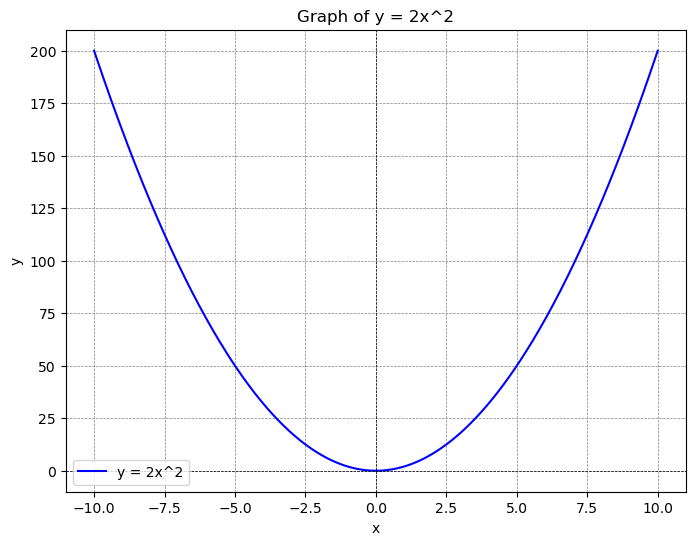

> {'output_1': '', 'output_2': "import numpy as np\nimport matplotlib.pyplot as plt\n\n# Define the range of x values\nx = np.linspace(-10, 10, 400)\n# Define the function y = 2x^2\ny = 2 * x**2\n\n# Create the plot\nplt.figure(figsize=(8, 6))\nplt.plot(x, y, label='y = 2x^2', color='blue')\nplt.title('Graph of y = 2x^2')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.axhline(0, color='black',linewidth=0.5, ls='--')\nplt.axvline(0, color='black',linewidth=0.5, ls='--')\nplt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)\nplt.legend()\nplt.show()"}

Observation: The code to plot the graph of y = 2x^2 has been generated and run successfully, but the output of the plot has not been displayed to the user yet.
Thoughts: To complete the assigned task, I need to pass the final output of the plot to the user, ensuring they can see the graph that was generated.
Subtask identified: End Task
Task completed successfully!



[{'output_1': '',
  'output_2': "import numpy as np\nimport matplotlib.pyplot as plt\n\n# Define the range of x values\nx = np.linspace(-10, 10, 400)\n# Define the function y = 2x^2\ny = 2 * x**2\n\n# Create the plot\nplt.figure(figsize=(8, 6))\nplt.plot(x, y, label='y = 2x^2', color='blue')\nplt.title('Graph of y = 2x^2')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.axhline(0, color='black',linewidth=0.5, ls='--')\nplt.axvline(0, color='black',linewidth=0.5, ls='--')\nplt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)\nplt.legend()\nplt.show()"}]

In [46]:
agent.reset()
agent.run('Plot me a graph of y = 2x^2')

In [47]:
agent.reset()
agent.run('What are the first 10 prime numbers?')

Observation: No subtasks have been completed yet for the task of identifying the first 10 prime numbers.
Thoughts: To complete the task, I need to generate a list of the first 10 prime numbers. This can be done by writing a simple algorithm to find prime numbers and then returning the first 10.
Subtask identified: Generate and run code to calculate the first 10 prime numbers using a simple algorithm.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Generate and run code to calculate the first 10 prime numbers using a simple algorithm.'}
Filtered Function Names: wikipedia_tool, python_generate_and_run_code_tool, get_text_from_url_tool
> {'output_1': '[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n', 'output_2': 'import math\n\n# Initialize variables\nprime_numbers = []\nnum = 2\n\n# Loop until we find the first 10 prime numbers\nwhile len(prime_numbers) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n      

[{'output_1': '[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]\n',
  'output_2': 'import math\n\n# Initialize variables\nprime_numbers = []\nnum = 2\n\n# Loop until we find the first 10 prime numbers\nwhile len(prime_numbers) < 10:\n    is_prime = True\n    for i in range(2, int(math.sqrt(num)) + 1):\n        if num % i == 0:\n            is_prime = False\n            break\n    if is_prime:\n        prime_numbers.append(num)\n    num += 1\n\n# Print the first 10 prime numbers\nprint(prime_numbers)'}]

In [48]:
agent.reset()
agent.run('Who is Joe Biden and how old is he now based on calculation?')

Observation: No subtasks have been completed yet for the assigned task of finding out who Joe Biden is and calculating his current age.
Thoughts: To complete the assigned task, I need to gather information about Joe Biden and then calculate his age based on the current date.
Subtask identified: First, I will search for information about Joe Biden using the Wikipedia tool to gather relevant details about his background and current status.
Calling function wikipedia_tool with parameters {'search_query': 'Joe Biden'}
> {'output_1': "Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (born November 20, 1942) is an American politician who is the 46th and current president of the United States since 2021. A member of the Democratic Party, he previously served as the 47th vice president from 2009 to 2017 under President Barack Obama and represented Delaware in the U.S. Senate from 1973 to 2009.\nBorn in Scranton, Pennsylvania, Biden moved with his family to Delaware in 1953. He graduated fr

[{'output_1': "Page: Joe Biden\nSummary: Joseph Robinette Biden Jr. (born November 20, 1942) is an American politician who is the 46th and current president of the United States since 2021. A member of the Democratic Party, he previously served as the 47th vice president from 2009 to 2017 under President Barack Obama and represented Delaware in the U.S. Senate from 1973 to 2009.\nBorn in Scranton, Pennsylvania, Biden moved with his family to Delaware in 1953. He graduated from the University of Delaware in 1965 before earning his law degree from Syracuse University in 1968. He was elected to the New Castle County Council in 1970 and to the U.S. Senate in 1972. As a senator, Biden drafted and led the effort to pass the Violent Crime Control and Law Enforcement Act and the Violence Against Women Act. He also oversaw six U.S. Supreme Court confirmation hearings, including the contentious hearings for Robert Bork and Clarence Thomas. Biden ran unsuccessfully for the 1988 and 2008 Democrati

In [49]:
agent.reply_user()

Joe Biden, whose full name is Joseph Robinette Biden Jr., is an American politician who is currently serving as the 46th president of the United States, a position he has held since January 20, 2021. He is a member of the Democratic Party and previously served as the 47th vice president from 2009 to 2017 under President Barack Obama. Biden represented Delaware in the U.S. Senate from 1973 to 2009. Born on November 20, 1942, in Scranton, Pennsylvania, he moved to Delaware with his family in 1953. Biden graduated from the University of Delaware in 1965 and earned his law degree from Syracuse University in 1968. He has had a long political career, including drafting significant legislation such as the Violent Crime Control and Law Enforcement Act and the Violence Against Women Act. Biden ran for the Democratic presidential nomination in 1988 and 2008 but was unsuccessful until he won the presidency in 2020, defeating incumbent Donald Trump.

As of now, Joe Biden is 81 years old. This calc

'Joe Biden, whose full name is Joseph Robinette Biden Jr., is an American politician who is currently serving as the 46th president of the United States, a position he has held since January 20, 2021. He is a member of the Democratic Party and previously served as the 47th vice president from 2009 to 2017 under President Barack Obama. Biden represented Delaware in the U.S. Senate from 1973 to 2009. Born on November 20, 1942, in Scranton, Pennsylvania, he moved to Delaware with his family in 1953. Biden graduated from the University of Delaware in 1965 and earned his law degree from Syracuse University in 1968. He has had a long political career, including drafting significant legislation such as the Violent Crime Control and Law Enforcement Act and the Violence Against Women Act. Biden ran for the Democratic presidential nomination in 1988 and 2008 but was unsuccessful until he won the presidency in 2020, defeating incumbent Donald Trump.\n\nAs of now, Joe Biden is 81 years old. This c

In [50]:
agent.reset()
agent.run('What are the number of stars in TaskGen GitHub? (https://github.com/simbianai/taskgen)')

Observation: No subtasks have been completed yet for the task of finding the number of stars in the TaskGen GitHub repository.
Thoughts: To complete the task, I need to retrieve the number of stars from the specified GitHub URL. This can be done by extracting the relevant information from the webpage.
Subtask identified: Use the get_text_from_url_tool to fetch the content of the GitHub repository page and then parse the number of stars from the retrieved text.
Calling function get_text_from_url_tool with parameters {'url': 'https://github.com/simbianai/taskgen'}
> {'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\nSign in\nProduct\nActions\nAutomate any workflow\nPackages\nHost and manage packages\nSecurity\nFind and fix vulnerabilities\nCodespaces\nInstant dev environments\nGitHub Copilot\nWrite better code with AI\nCode review\nManage code changes\nIssues\nPlan and track work\nDiscu

[{'output_1': 'GitHub - simbianai/taskgen: Task-based Agentic Framework using StrictJSON as the core\nSkip to content\nNavigation Menu\nToggle navigation\nSign in\nProduct\nActions\nAutomate any workflow\nPackages\nHost and manage packages\nSecurity\nFind and fix vulnerabilities\nCodespaces\nInstant dev environments\nGitHub Copilot\nWrite better code with AI\nCode review\nManage code changes\nIssues\nPlan and track work\nDiscussions\nCollaborate outside of code\nExplore\nAll features\nDocumentation\nGitHub Skills\nBlog\nSolutions\nBy size\nEnterprise\nTeams\nStartups\nBy industry\nHealthcare\nFinancial services\nManufacturing\nBy use case\nCI/CD & Automation\nDevOps\nDevSecOps\nResources\nTopics\nAI\nDevOps\nInnersource\nOpen Source\nSecurity\nSoftware Development\nExplore\nLearning Pathways\nWhite papers, Ebooks, Webinars\nCustomer Stories\nPartners\nOpen Source\nGitHub Sponsors\nFund open source developers\nThe ReadME Project\nGitHub community articles\nRepositories\nTopics\nTrending

In [51]:
agent.reply_user()

The number of stars in the TaskGen GitHub repository (https://github.com/simbianai/taskgen) is 100. This information was extracted from the retrieved GitHub page text using a Python script that utilized regex to find the number of stars mentioned in the text. The relevant code used for extraction was:

```python
import re

url = "https://github.com/simbianai/taskgen"
text = get_text_from_url_tool(url=url)

# Extract the number of stars using regex
stars = re.findall(r"\\b(\\d+)\\s+stars\\b", text["output_1"])

# Print the number of stars
print(stars[0] if stars else "No stars found")
```

This confirms that the TaskGen repository has 100 stars.


'The number of stars in the TaskGen GitHub repository (https://github.com/simbianai/taskgen) is 100. This information was extracted from the retrieved GitHub page text using a Python script that utilized regex to find the number of stars mentioned in the text. The relevant code used for extraction was:\n\n```python\nimport re\n\nurl = "https://github.com/simbianai/taskgen"\ntext = get_text_from_url_tool(url=url)\n\n# Extract the number of stars using regex\nstars = re.findall(r"\\\\b(\\\\d+)\\\\s+stars\\\\b", text["output_1"])\n\n# Print the number of stars\nprint(stars[0] if stars else "No stars found")\n```\n\nThis confirms that the TaskGen repository has 100 stars.'

# Code as Action
- Executable Code Actions Elicit Better LLM Agents (Wang et al, 2024)
- https://arxiv.org/abs/2402.01030

- **How to use it**: Equip `python_generate_and_run_code_tool` and set `code_action = True` to make this function be used as default other than `end_task`. Also mention to use `python_generate_and_run_code_tool` as default in the Agent prompt.

- My take:
    - It is not as robust as the way we do modular function calling like the rest of TaskGen
    - Should use better LLMs like `gpt-4o-mini` to be viable
    - Try to specify 'at one go' in the task to encourage LLM to use all Equipped Functions in the same code

In [52]:
def return_random_person() -> str:
    '''Returns a random person name'''
    import numpy as np
    return np.random.choice(['Alice', 'Bob', 'Cindy', 'Don', 'Edward'])

In [53]:
agent = Agent('Code Agent', 
'''Uses code to solve tasks''',
              code_action = True, # this forces python_generate_and_run_code_tool to be the default action
             summarise_subtasks_count = 10,
             llm = llm).assign_functions(
    [python_generate_and_run_code_tool, return_random_person])

In [54]:
agent.reset()
agent.run('Generate three random names in one go')

Observation: No subtasks have been completed yet for the task of generating three random names.
Thoughts: To complete the assigned task, I can utilize the return_random_person function to generate random names. Since I need three names, I will call this function three times.
Subtask identified: Call the return_random_person function three times to generate three random names.
Calling function python_generate_and_run_code_tool with parameters {'instruction': 'Call the return_random_person function three times to generate three random names.'}
Filtered Function Names: python_generate_and_run_code_tool, return_random_person
> {'output_1': "{'output_1': 'Alice'}\n{'output_1': 'Edward'}\n{'output_1': 'Don'}\n", 'output_2': 'import random\n\nname1 = return_random_person()\nname2 = return_random_person()\nname3 = return_random_person()\n\nprint(name1)\nprint(name2)\nprint(name3)'}

Observation: Three random names have been successfully generated: Alice, Edward, and Don. The code to generate t

[{'output_1': "{'output_1': 'Alice'}\n{'output_1': 'Edward'}\n{'output_1': 'Don'}\n",
  'output_2': 'import random\n\nname1 = return_random_person()\nname2 = return_random_person()\nname3 = return_random_person()\n\nprint(name1)\nprint(name2)\nprint(name3)'}]